# Import Data

Setting up all the import Statements

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE

from tensorflow.keras.utils import plot_model

random_state = 3

2024-06-08 20:59:15.979835: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Plotting Function

In [11]:
def plot_model_history(history):
    """Plot the training and validation history for a TensorFlow network"""

    # Extract loss and accuracy
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    mape = history.history["MAPE"]
    val_MAPE = history.history["val_MAPE"]
    n_epochs = len(loss)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
    ax.plot(np.arange(n_epochs), loss, label="Training")
    ax.plot(np.arange(n_epochs), val_loss, label="Validation")
    ax.legend()
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Loss")
    #ax.savefig("Plots/NNAllData1Layer")

    #ax[1].plot(np.arange(n_epochs), mape, label="Training")
    #ax[1].plot(np.arange(n_epochs), val_MAPE, label="Validation")
    #ax[1].legend()
    #ax[1].set_xlabel("Epoch")
    #ax[1].set_ylabel("Mean Absolute Percent Error")


In [29]:
#Getting the Data
NN_data = pd.read_csv("Data/NNData.csv")

# The NN_data is a 1095 by 30 dataframe. Where there are 30 columns each having 1095 data points.
# This corresponds to 3 years of data. 

# Splitting it up into hot and cold. For use if wanted
NN_data_hot = NN_data[NN_data["AvgDB"] >= 61]
NN_data_cold = NN_data[NN_data["AvgDB"] < 61]

NN_data.values[:,5]

array([0.0, 0.0, 0.0, ..., 0.0, 0.0, 0.0], dtype=object)

In [19]:
# Splitting the X values from the other values. 
X = NN_data.values[:,3:]
# The y values are in the 3rd column. (Actual Energy)
y = NN_data.values[:,2]

# These are the values of X that are supposed to be non-linear in the paper. 
X_NonLinear = NN_data[["AvgDB","LagDB", "AvgClouds", "AvgWind", "Trend2010", "Lag2DB", 'Monday', 'Tuesday', 'Wednesday',
       'Thursday', 'Friday', 'Saturday']]
X_temp = NN_data[["AvgDB"]]
# Splitting Data into training and testing.
X_train, X_test, y_train, y_test = train_test_split(X_NonLinear, y, test_size=0.1, random_state=random_state)


In [20]:
# To go through the model all data has to be float 32s.
X_train = np.asarray(X_train).astype('float32')
X_test= np.asarray(X_test).astype('float32')
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_test).astype('float32')

# We have to scale both our x and y data using scalars because with activations,
# having high values will mean all nodes are the same. 
scaler_x = StandardScaler()
scaler_y = MinMaxScaler()

# Now using our scalers we have to transform all our data. 
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
y_train = scaler_y.fit_transform(y_train.reshape(-1,1)).reshape(-1,)


In [22]:
# Initialize the model. 
model = Sequential()
# For each layer you need to add the number of Neurons and the activation. 
# We have 27 features so that goes in input_shape
model.add(Dense(4, input_shape=(12,)))
model.add(Activation(activation="sigmoid"))
model.add(Dense(1))
model.summary()

model.compile(optimizer="Adam", loss=["MSE"], metrics=["MAE", "MAPE"])
history = model.fit(X_train, y_train, batch_size=2, epochs=150, validation_split=0.25, shuffle=True, verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 4)                 52        
                                                                 
 activation_3 (Activation)   (None, 4)                 0         
                                                                 
 dense_7 (Dense)             (None, 1)                 5         
                                                                 
Total params: 57 (228.00 Byte)
Trainable params: 57 (228.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/150
369/369 [==============================] - 3s 5ms/step - loss: 0.1048 - MAE: 0.2554 - MAPE: 158.1552 - val_loss: 0.0414 - val_MAE: 0.1698 - val_MAPE: 1115002.0000
Epoch 2/150
369/369 [==============================] - 2s 5ms/step - loss: 0.0321 - MAE: 0.1430 - MAPE: 109

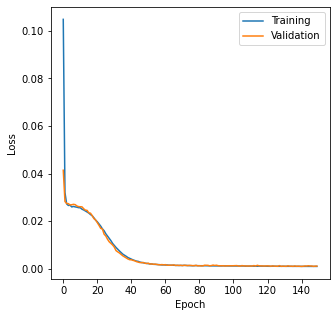

In [23]:
plot_model_history(history)

In [24]:
#np.shape(X_test_hot)
y_keras = model.predict(X_test, batch_size=1, verbose=0)

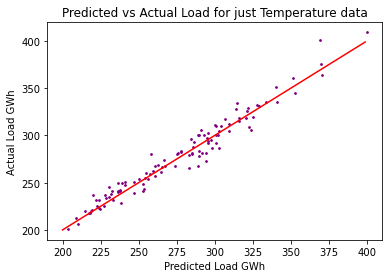

In [25]:
plt.scatter(scaler_y.inverse_transform(y_keras), y_test, s = 3, color = 'purple')
plt.xlabel('Predicted Load GWh')
plt.ylabel('Actual Load GWh')
plt.plot(np.arange(200,400), np.arange(200,400), color = "r")
plt.title("Predicted vs Actual Load for just Temperature data")
plt.savefig("Plots/NNAllDataScatter2.png")
plt.show()

In [26]:
print(f"MAPE = {MAPE(y_test, scaler_y.inverse_transform(y_keras))}")

MAPE = 0.024826865643262863


In [16]:
#!pip install graphviz
#!pip install pydot

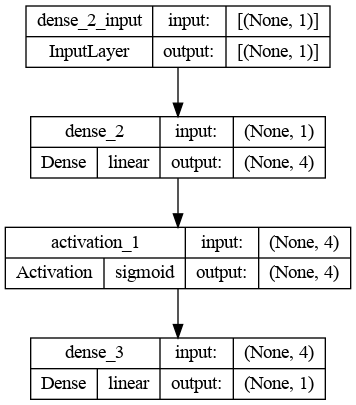

In [17]:
plot_model(model, to_file="Plots/BasicNNAllData.png",
           show_shapes=True, show_layer_activations=True)